In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.eval_measures import rmse
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error,make_scorer
from typing import Union
from scipy import stats
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

## **Cargar Datos**

In [2]:
# Enlace
url='https://raw.githubusercontent.com/Saul-Ochoa/MachineLearning/refs/heads/main/Ridge%26Lazzo/Data/meatspec.csv'
df=pd.read_csv(url)
df.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V92,V93,V94,V95,V96,V97,V98,V99,V100,fat
0,1,2.61776,2.61814,2.61859,2.61912,2.61981,2.62071,2.62186,2.62334,2.62511,...,2.98145,2.96072,2.94013,2.91978,2.89966,2.87964,2.85960,2.83940,2.81920,22.5
1,2,2.83454,2.83871,2.84283,2.84705,2.85138,2.85587,2.86060,2.86566,2.87093,...,3.29186,3.27921,3.26655,3.25369,3.24045,3.22659,3.21181,3.19600,3.17942,40.1
2,3,2.58284,2.58458,2.58629,2.58808,2.58996,2.59192,2.59401,2.59627,2.59873,...,2.68951,2.67009,2.65112,2.63262,2.61461,2.59718,2.58034,2.56404,2.54816,8.4
3,4,2.82286,2.82460,2.82630,2.82814,2.83001,2.83192,2.83392,2.83606,2.83842,...,2.97367,2.94951,2.92576,2.90251,2.87988,2.85794,2.83672,2.81617,2.79622,5.9
4,5,2.78813,2.78989,2.79167,2.79350,2.79538,2.79746,2.79984,2.80254,2.80553,...,3.30025,3.27907,3.25831,3.23784,3.21765,3.19766,3.17770,3.15770,3.13753,25.5


In [3]:
# eliminar columna Unnamed
df.drop('Unnamed: 0',axis=1,inplace=True)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V92,V93,V94,V95,V96,V97,V98,V99,V100,fat
0,2.61776,2.61814,2.61859,2.61912,2.61981,2.62071,2.62186,2.62334,2.62511,2.62722,...,2.98145,2.96072,2.94013,2.91978,2.89966,2.87964,2.85960,2.83940,2.81920,22.5
1,2.83454,2.83871,2.84283,2.84705,2.85138,2.85587,2.86060,2.86566,2.87093,2.87661,...,3.29186,3.27921,3.26655,3.25369,3.24045,3.22659,3.21181,3.19600,3.17942,40.1
2,2.58284,2.58458,2.58629,2.58808,2.58996,2.59192,2.59401,2.59627,2.59873,2.60131,...,2.68951,2.67009,2.65112,2.63262,2.61461,2.59718,2.58034,2.56404,2.54816,8.4
3,2.82286,2.82460,2.82630,2.82814,2.83001,2.83192,2.83392,2.83606,2.83842,2.84097,...,2.97367,2.94951,2.92576,2.90251,2.87988,2.85794,2.83672,2.81617,2.79622,5.9
4,2.78813,2.78989,2.79167,2.79350,2.79538,2.79746,2.79984,2.80254,2.80553,2.80890,...,3.30025,3.27907,3.25831,3.23784,3.21765,3.19766,3.17770,3.15770,3.13753,25.5


In [4]:
# cantidad de filas y columnas
print(f'Cantidad de filas y columnas {df.shape}')

# vacios
#print(df.isnull().sum())

# suma de vacios
print(f'Total de vacios {df.isnull().sum().sum()}')

Cantidad de filas y columnas (215, 101)
Total de vacios 0


## **EDA**

In [5]:
corr_matrix=df.corr(method='pearson')
tril = np.tril(np.ones(corr_matrix.shape)).astype(bool)
corr_matrix[tril] = np.nan
corr_matrix_tidy = corr_matrix.stack().reset_index(name='r')
corr_matrix_tidy = corr_matrix_tidy.rename(columns={'level_0': 'variable_1', 'level_1': 'variable_2'})
corr_matrix_tidy = corr_matrix_tidy.dropna()
corr_matrix_tidy['r_abs'] = corr_matrix_tidy['r'].abs()
corr_matrix_tidy = corr_matrix_tidy.sort_values('r_abs', ascending=False).reset_index(drop=True)
corr_matrix_tidy

,variable_1,variable_2,r,r_abs
0,V10,V11,0.999996,0.999996
1,V11,V12,0.999996,0.999996
2,V9,V10,0.999996,0.999996
3,V12,V13,0.999996,0.999996
4,V8,V9,0.999995,0.999995
...,...,...,...,...
5045,V5,fat,0.366019,0.366019
5046,V9,fat,0.365803,0.365803
5047,V6,fat,0.365604,0.365604
5048,V8,fat,0.365483,0.365483


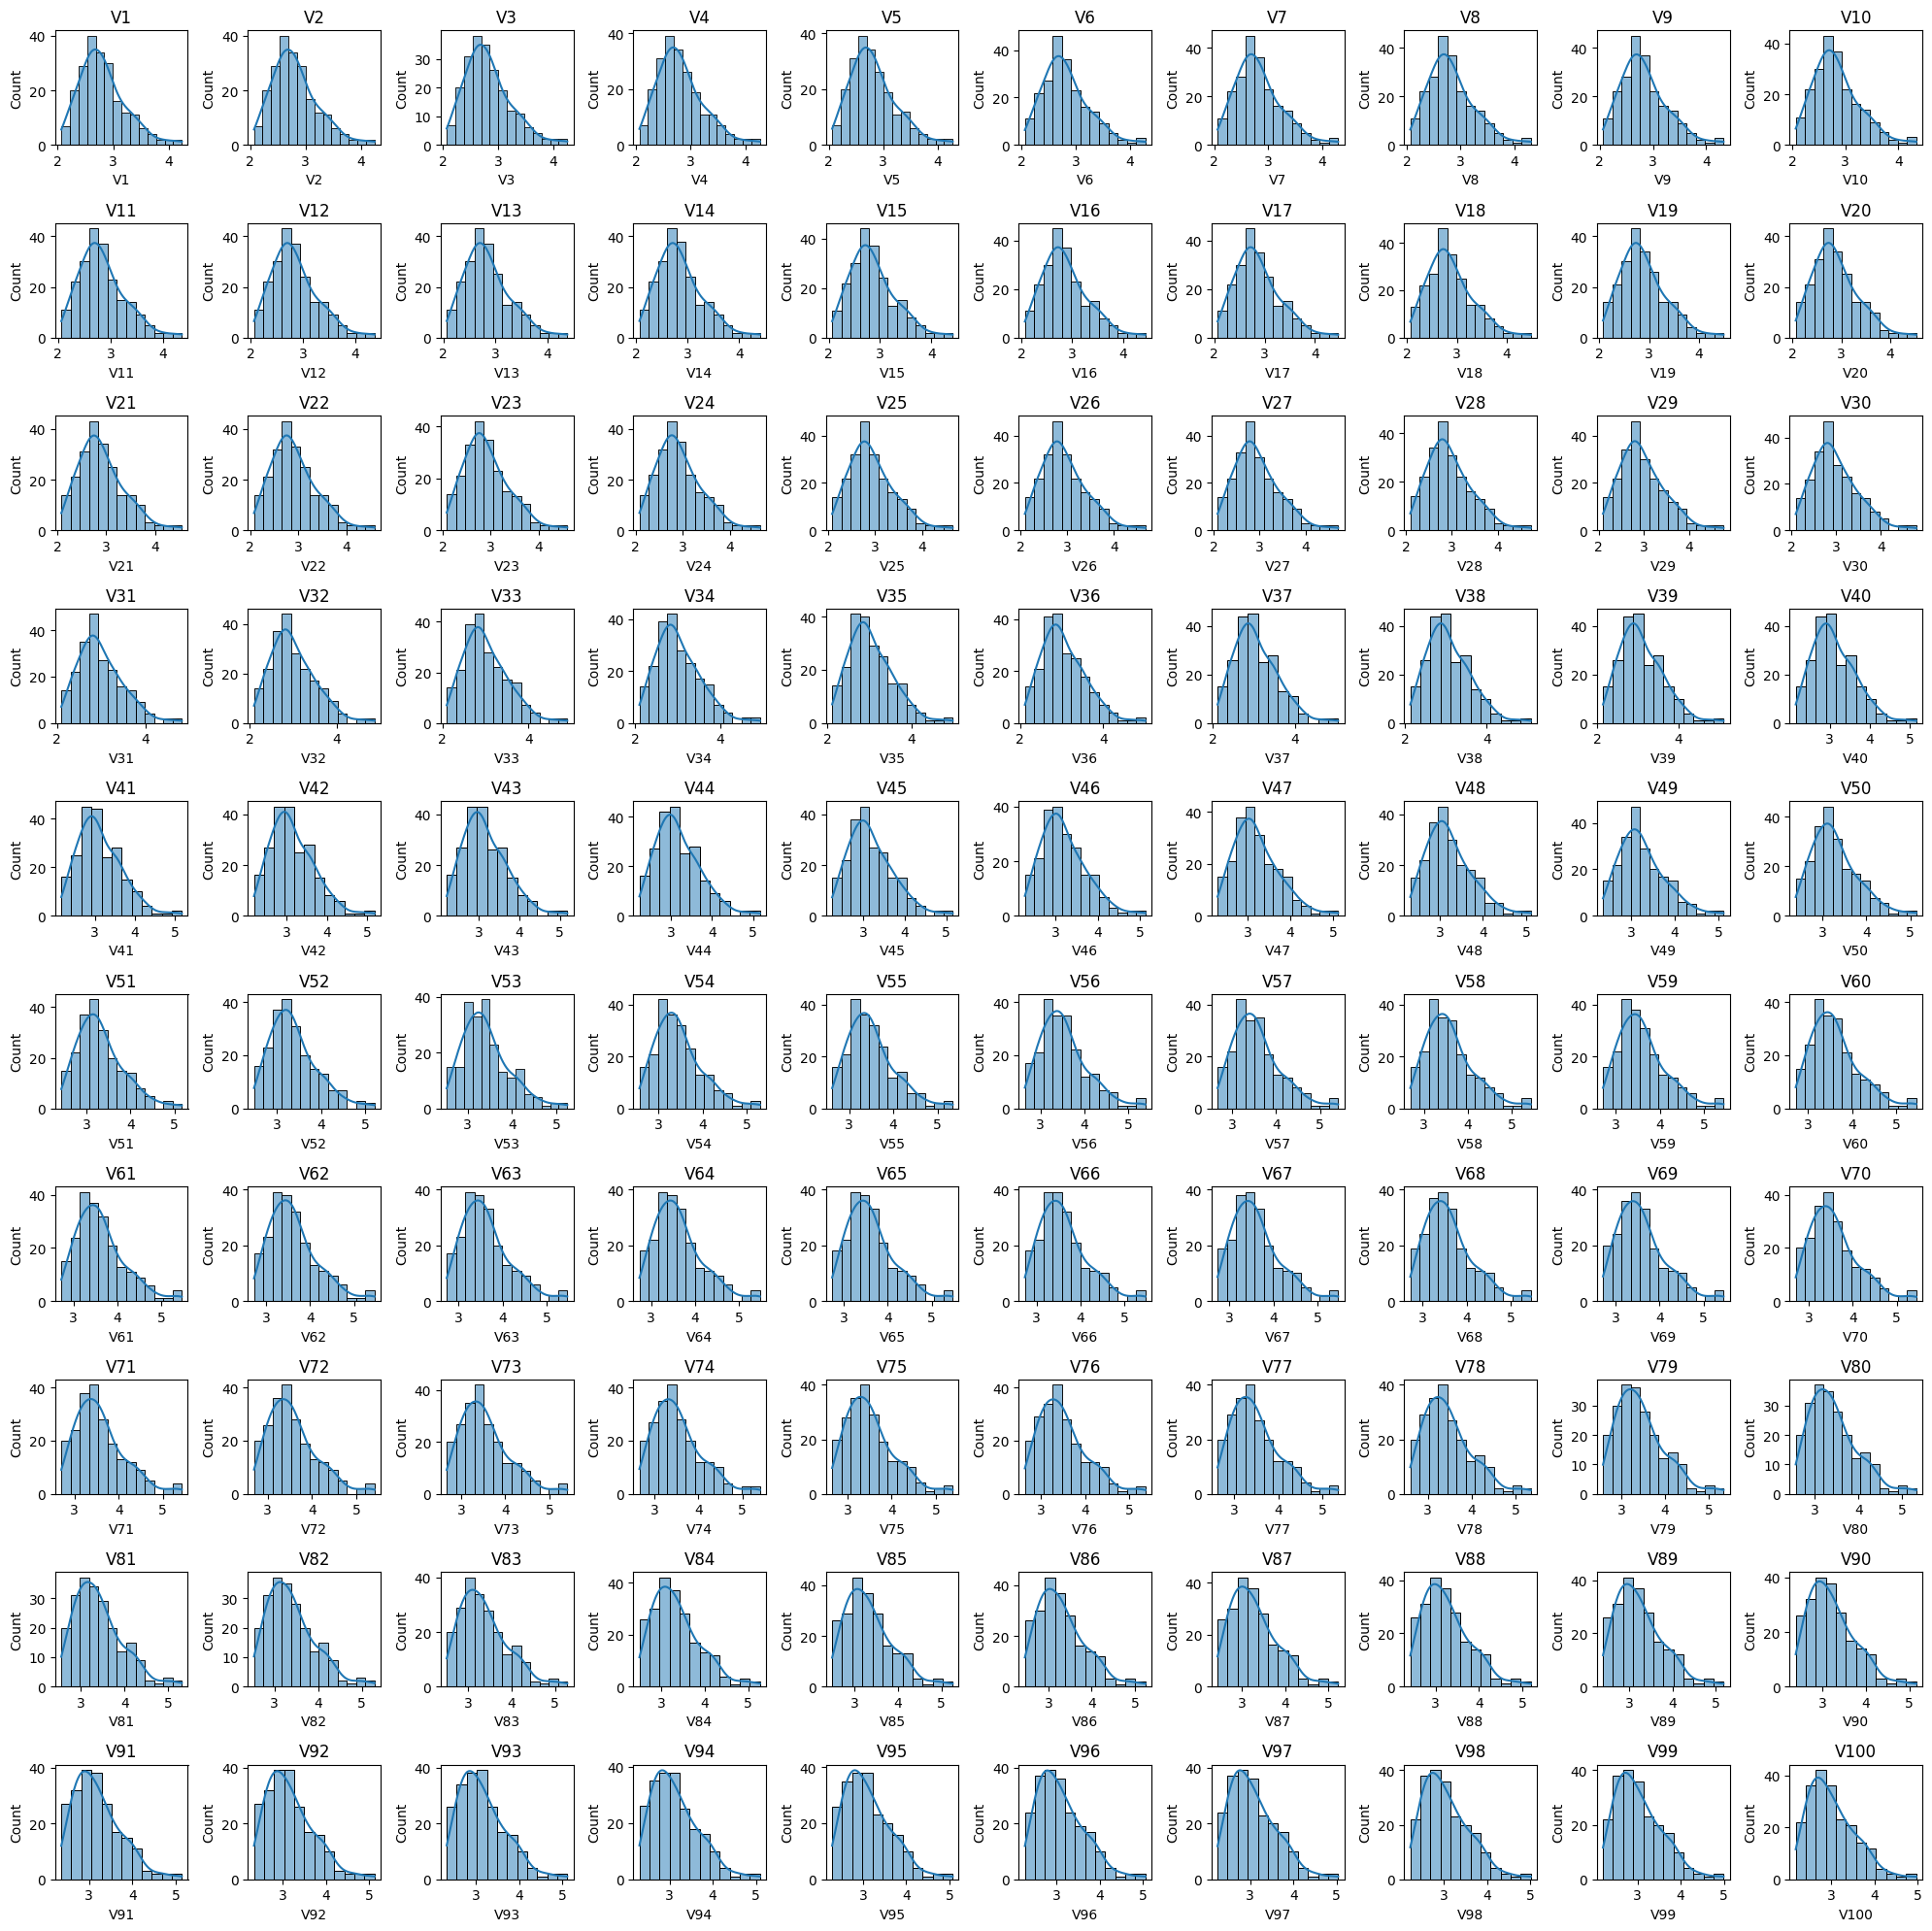

In [6]:
# Calcula el número de filas y columnas necesarias
n_cols = 10
n_rows = 10
n_plots = len(df.columns)


# Crea la figura y la cuadrícula de subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20))


# Itera sobre los subplots y los nombres de columna
for i, (ax, col) in enumerate(zip(axs.flat, df.columns)):
    sns.histplot(data=df, x=col, kde=True, ax=ax)
    ax.set_title(col)


# Oculta los subplots vacíos
for ax in axs.flat[i+1:]:
    ax.set_visible(False)


# Muestra la figura
plt.tight_layout()
plt.show()

* Tal como se evidencia en las graficas se presenta una distribucion en el histograma con cola hacia la izquierda.

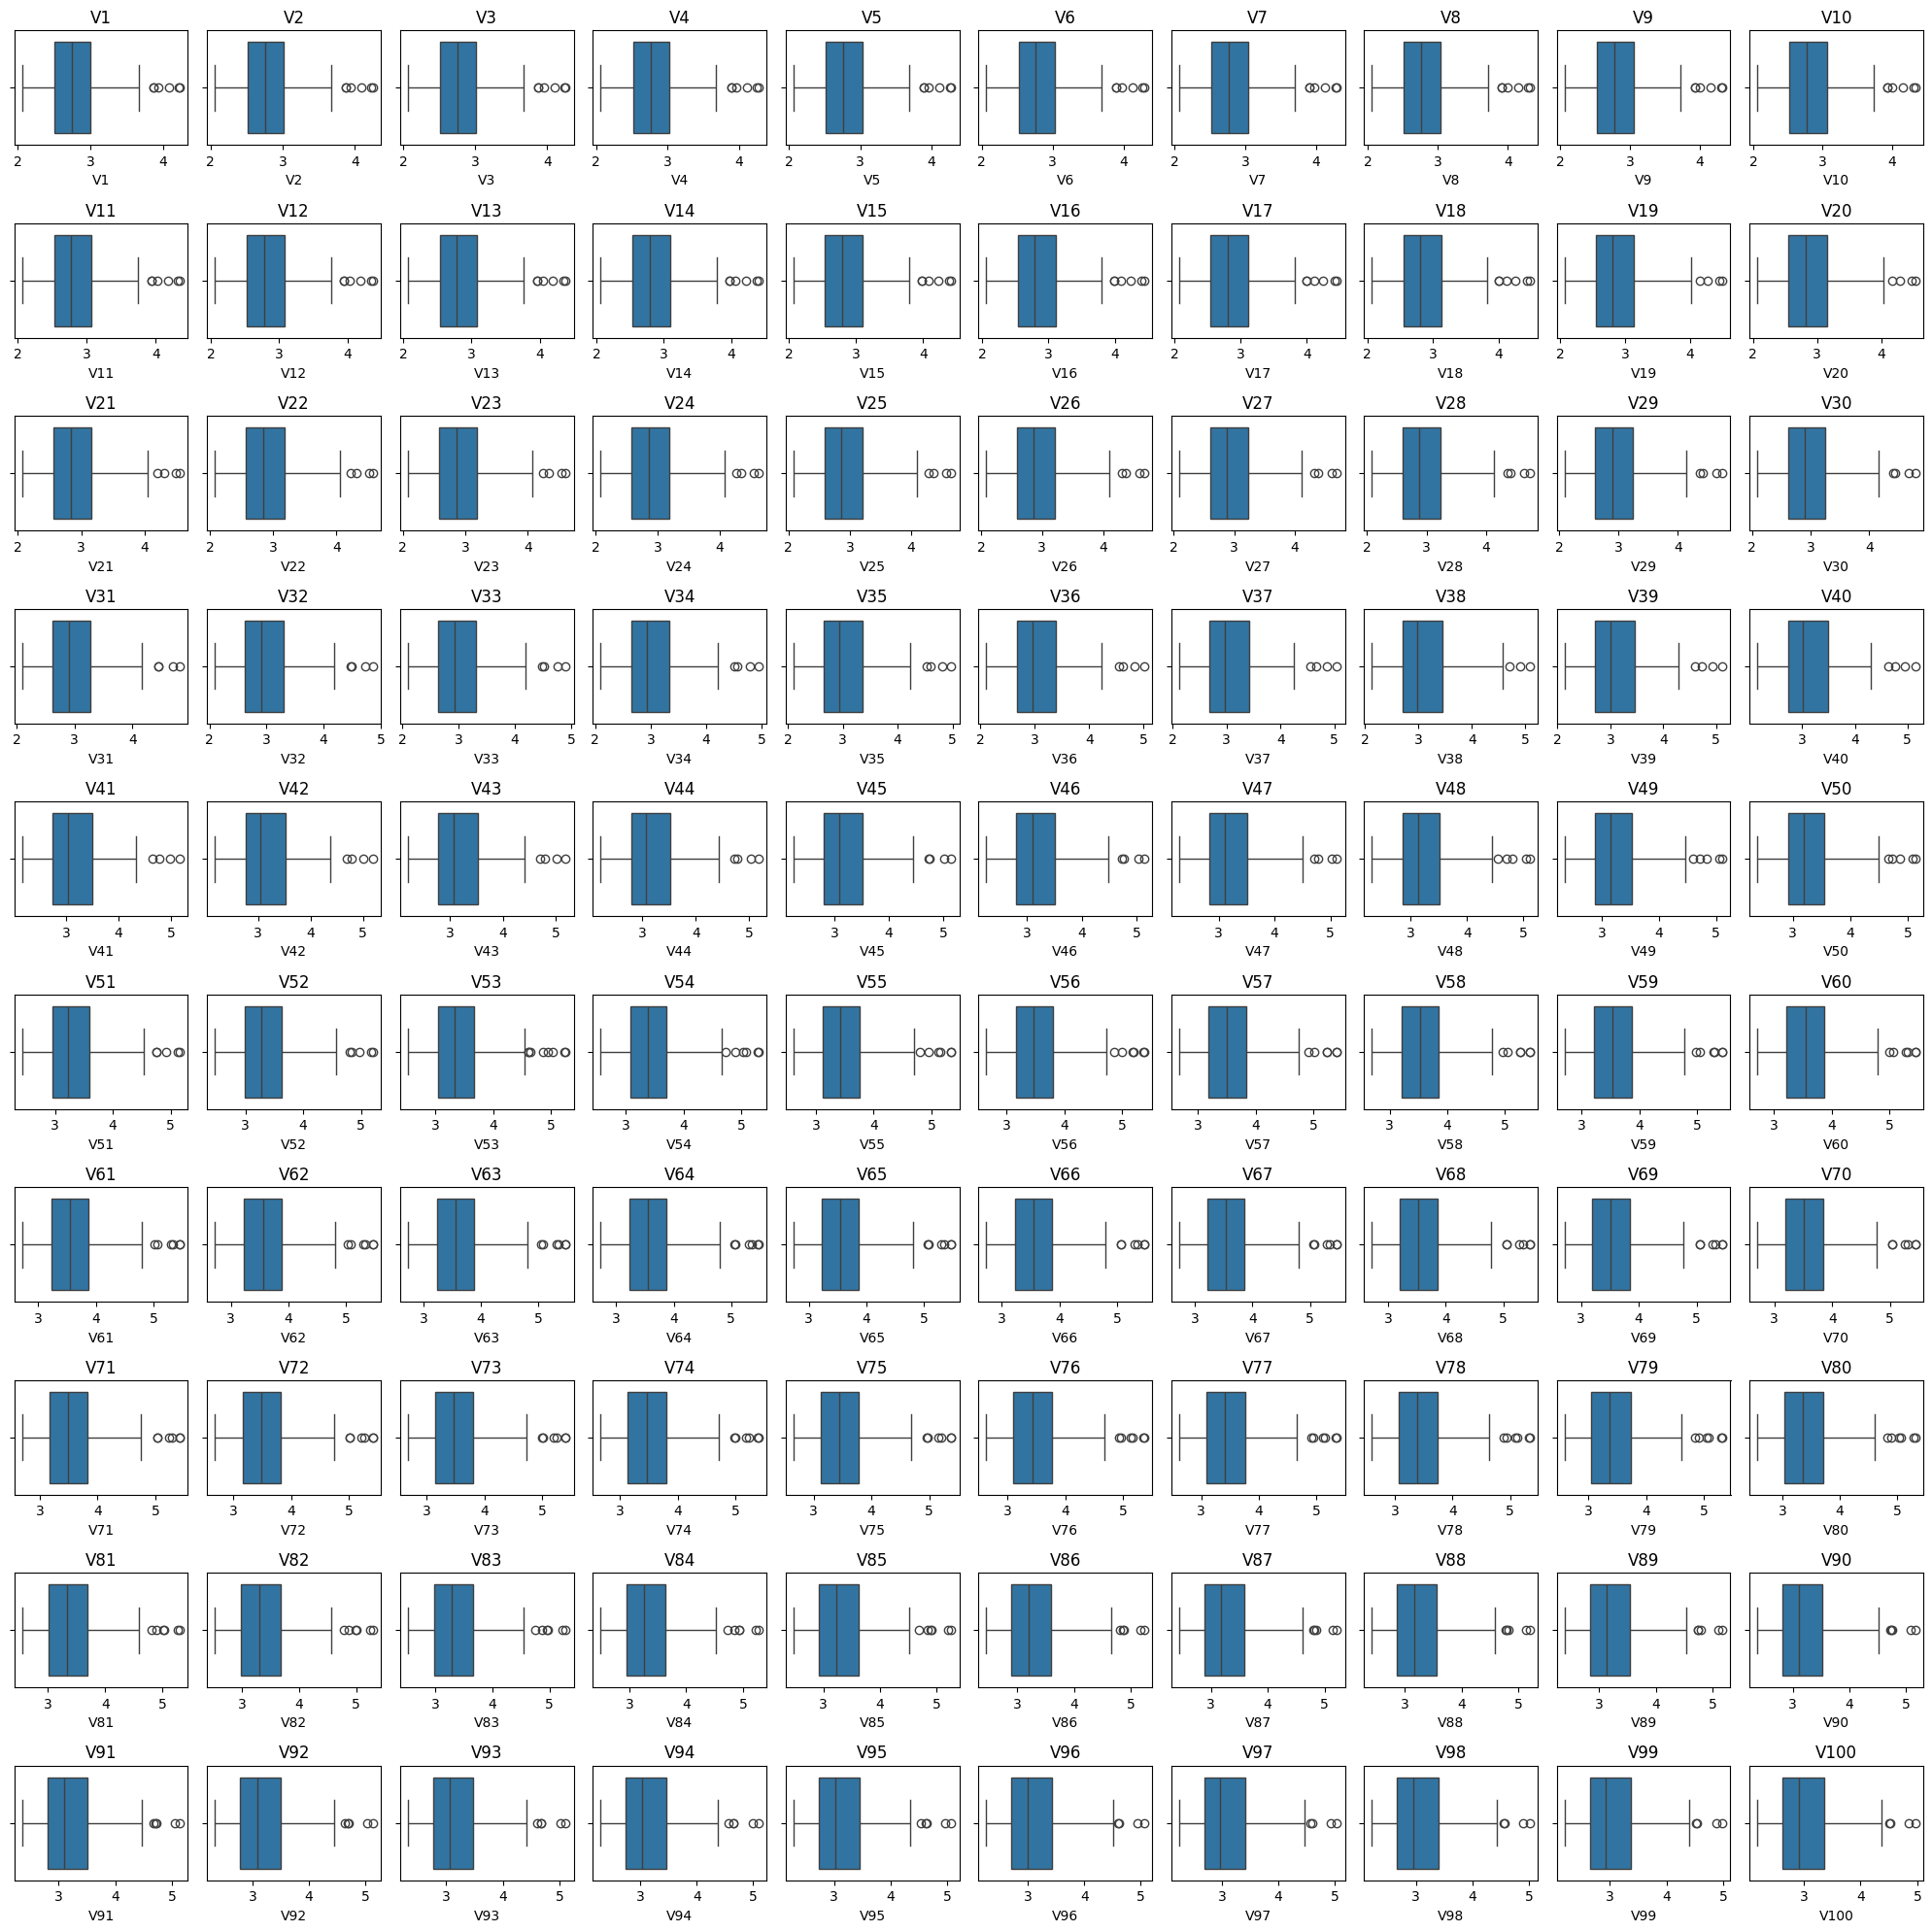

In [7]:
# Calcula el número de filas y columnas necesarias
n_cols = 10
n_rows = 10
n_plots = len(df.columns)


# Crea la figura y la cuadrícula de subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20))


# Itera sobre los subplots y los nombres de columna
for i, (ax, col) in enumerate(zip(axs.flat, df.columns)):
    sns.boxplot(data=df, x=col, ax=ax)
    ax.set_title(col)


# Oculta los subplots vacíos
for ax in axs.flat[i+1:]:
    ax.set_visible(False)


# Muestra la figura
plt.tight_layout()
plt.show()

## **Data Preparation**

In [8]:
# Función para eliminar outliers utilizando IQR
def remove_outliers_iqr(df):
  # Definir percentiles
  Q1=df.quantile(0.25)
  Q3=df.quantile(0.75)
  IQR=Q3-Q1

  # Filtrar los outliers
  df_clean=df[~((df<(Q1-1.5*IQR))|(df>(Q3+1.5*IQR))).any(axis=1)]
  return df_clean

df_clean=remove_outliers_iqr(df)
df_clean.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V92,V93,V94,V95,V96,V97,V98,V99,V100,fat
0,2.61776,2.61814,2.61859,2.61912,2.61981,2.62071,2.62186,2.62334,2.62511,2.62722,...,2.98145,2.96072,2.94013,2.91978,2.89966,2.87964,2.85960,2.83940,2.81920,22.5
1,2.83454,2.83871,2.84283,2.84705,2.85138,2.85587,2.86060,2.86566,2.87093,2.87661,...,3.29186,3.27921,3.26655,3.25369,3.24045,3.22659,3.21181,3.19600,3.17942,40.1
2,2.58284,2.58458,2.58629,2.58808,2.58996,2.59192,2.59401,2.59627,2.59873,2.60131,...,2.68951,2.67009,2.65112,2.63262,2.61461,2.59718,2.58034,2.56404,2.54816,8.4
3,2.82286,2.82460,2.82630,2.82814,2.83001,2.83192,2.83392,2.83606,2.83842,2.84097,...,2.97367,2.94951,2.92576,2.90251,2.87988,2.85794,2.83672,2.81617,2.79622,5.9
4,2.78813,2.78989,2.79167,2.79350,2.79538,2.79746,2.79984,2.80254,2.80553,2.80890,...,3.30025,3.27907,3.25831,3.23784,3.21765,3.19766,3.17770,3.15770,3.13753,25.5


In [9]:
df_clean.shape

(207, 101)

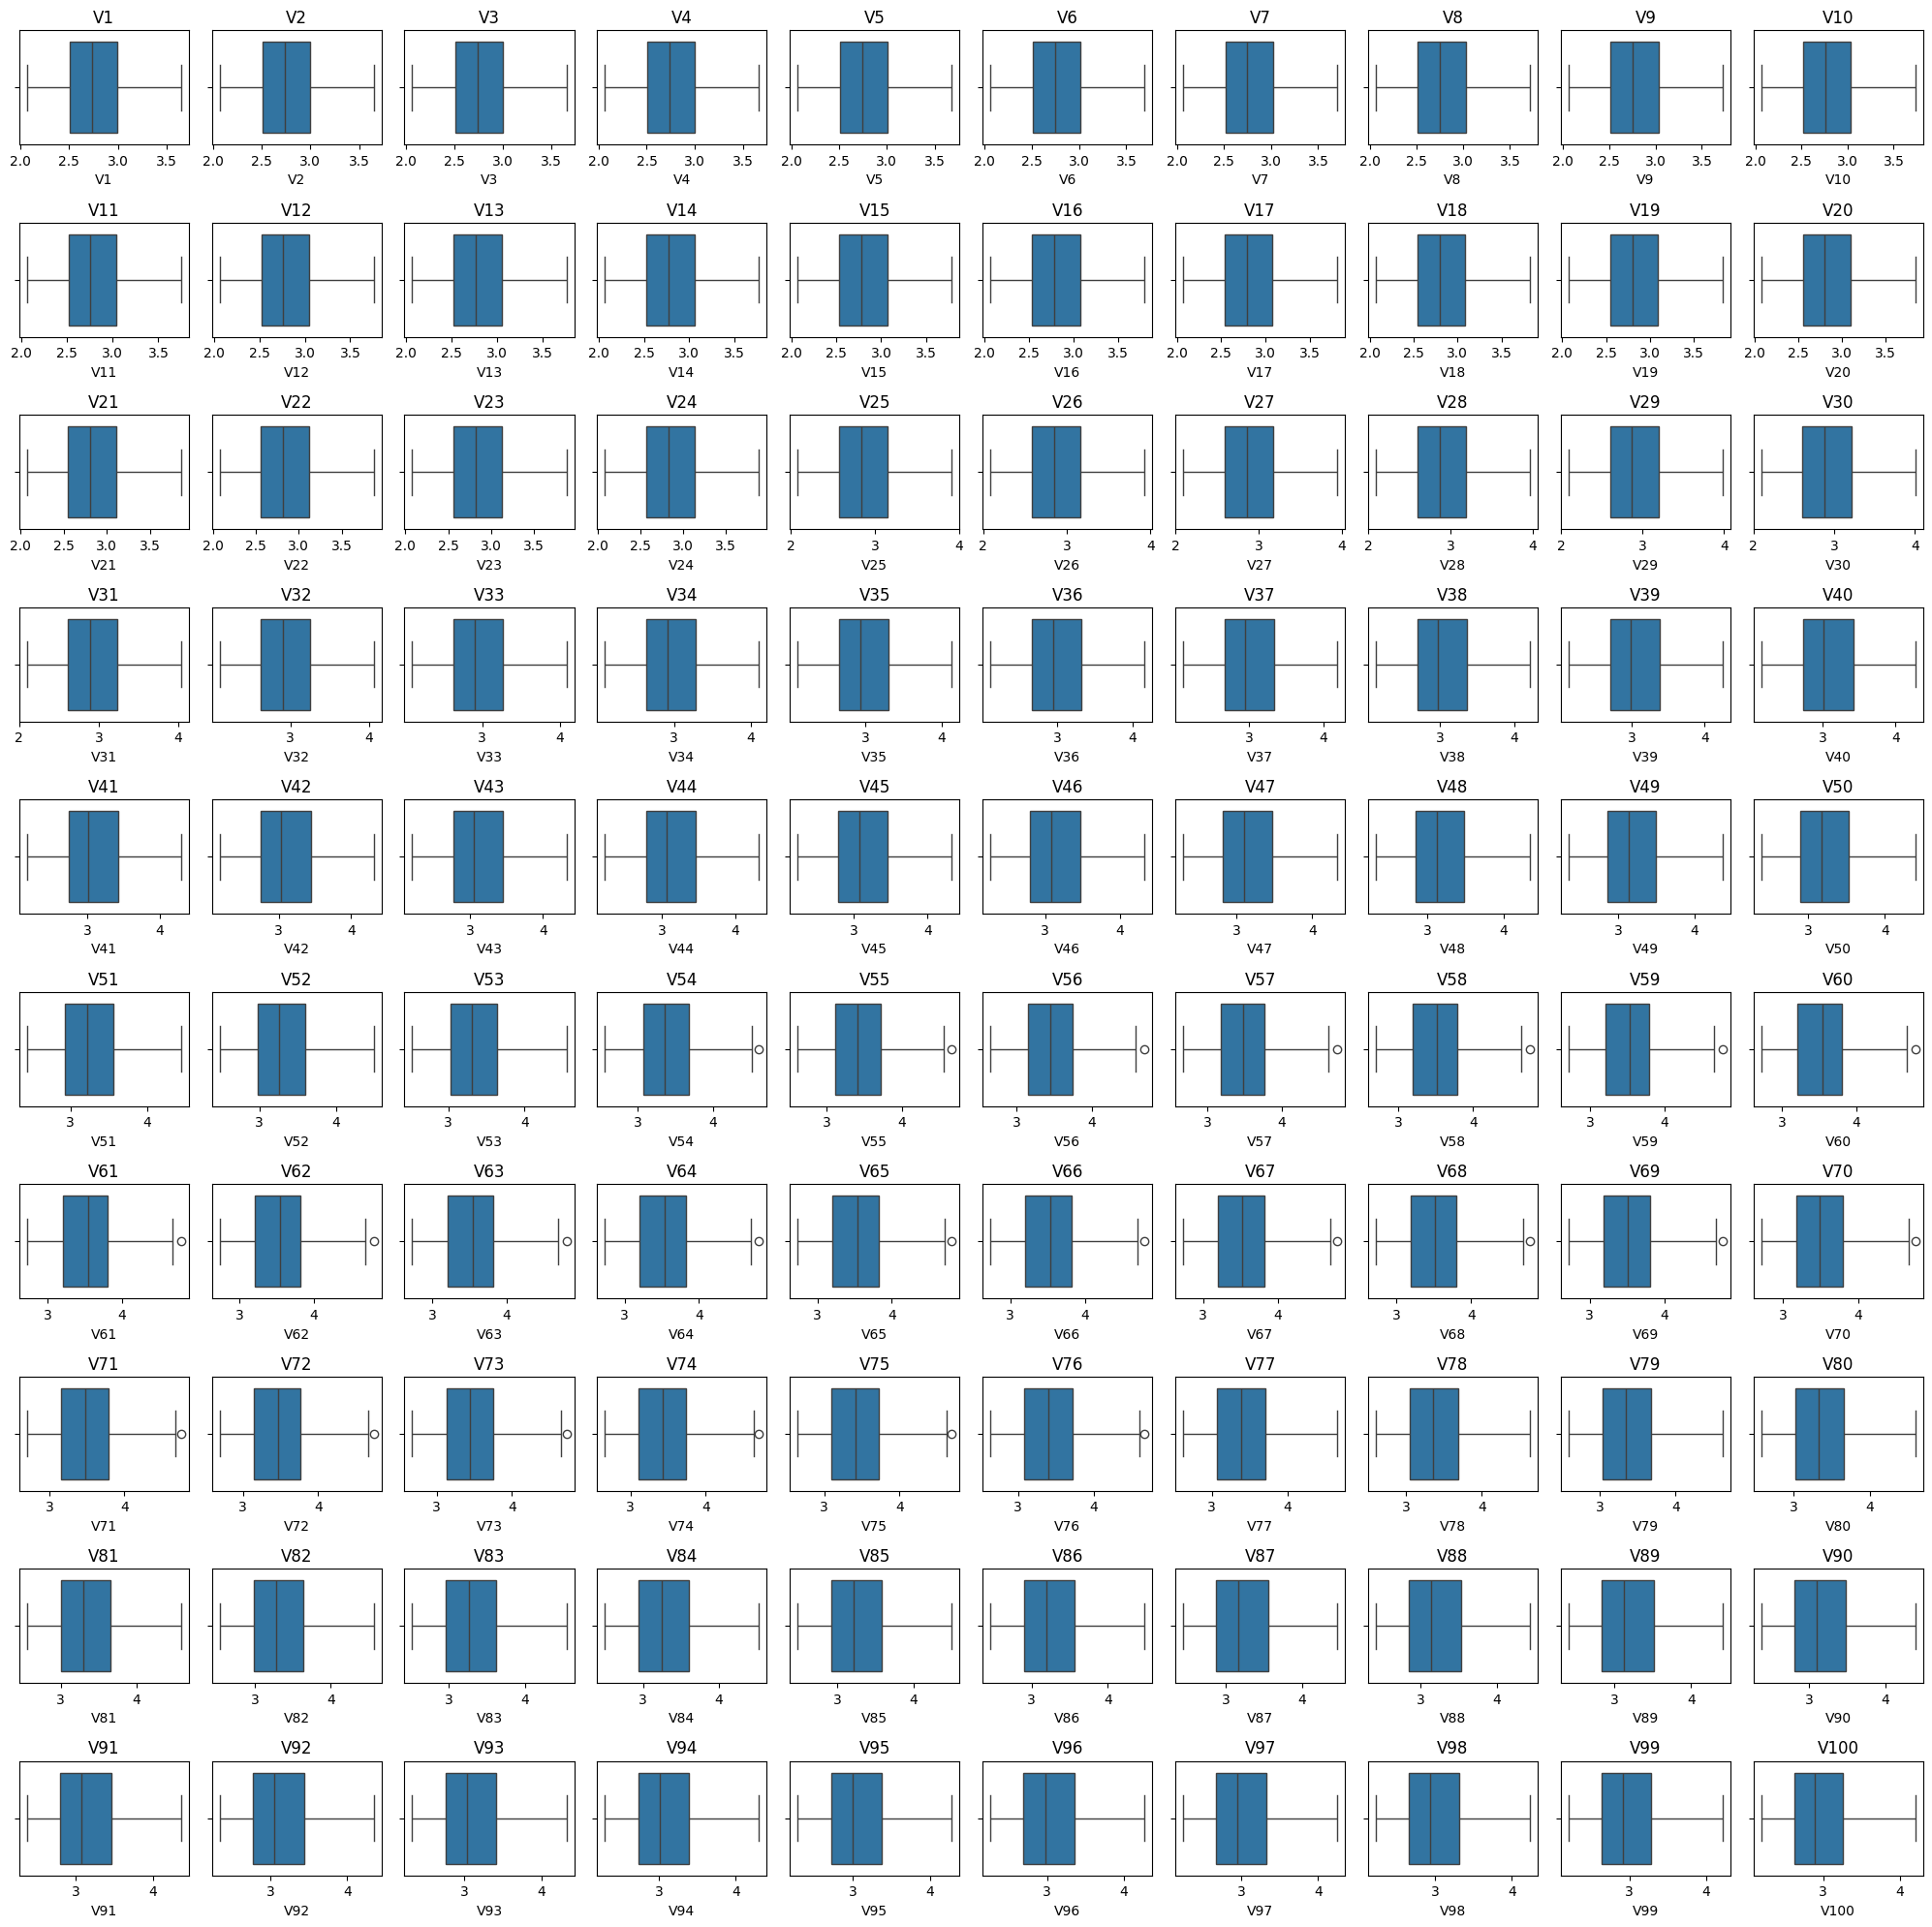

In [10]:
# Calcula el número de filas y columnas necesarias
n_cols = 10
n_rows = 10
n_plots = len(df_clean.columns)


# Crea la figura y la cuadrícula de subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20))


# Itera sobre los subplots y los nombres de columna
for i, (ax, col) in enumerate(zip(axs.flat, df_clean.columns)):
    sns.boxplot(data=df_clean, x=col, ax=ax)
    ax.set_title(col)


# Oculta los subplots vacíos
for ax in axs.flat[i+1:]:
    ax.set_visible(False)


# Muestra la figura
plt.tight_layout()
plt.show()

In [11]:
X=df_clean.drop('fat',axis=1)
y=df_clean['fat']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **Model of Machine Learning**

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

* **Linear Regression**

In [13]:
lr=LinearRegression()

# Ajusta el modelo a los datos de entrenamiento
lr.fit(X_train,y_train)

# Realiza predicciones en los datos de prueba
y_pred = lr.predict(X_test)

# Evalúa el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)


print('Mean Squared Error:', mse)
print('R-squared:', r2)
print('Mean Absolute Error:', mae)

Mean Squared Error: 6.584837589668793
R-squared: 0.9563959031190782
Mean Absolute Error: 1.969876490693179


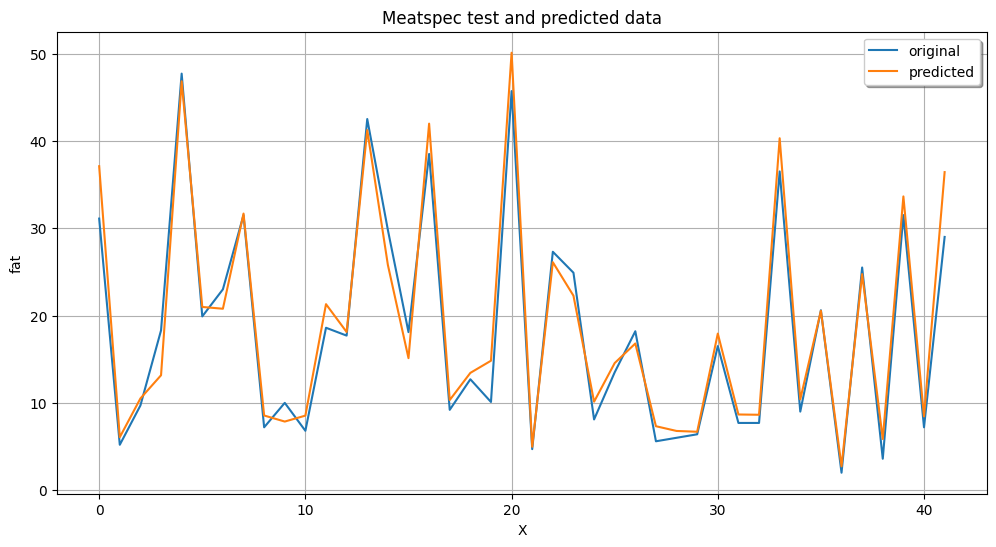

In [14]:
# visualizing in a plot
x_ax = range(len(y_test))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Meatspec test and predicted data")
plt.xlabel('X')
plt.ylabel('fat')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

In [15]:

# Definir hiperparámetros para ajustar
param_grid = {
    'alpha': [0.01,0.1, 0.5, 1, 5, 10],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg']
}

# Crear modelo Ridge
model = Ridge()

# Crear objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# Ajusta el modelo a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Realiza predicciones en los datos de prueba
y_pred = best_model.predict(X_test)

# Evalúa el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE en los datos de prueba: {mse}")
print(f"MAE en los datos de prueba: {mae}")
print(f"R² en los datos de prueba: {r2}")
print(f'Mejores hiperparámetros: {grid_search.best_params_}')

MSE en los datos de prueba: 7.517472920898172
MAE en los datos de prueba: 2.1435369216504885
R² en los datos de prueba: 0.9502200907647538
Mejores hiperparámetros: {'alpha': 0.01, 'solver': 'auto'}


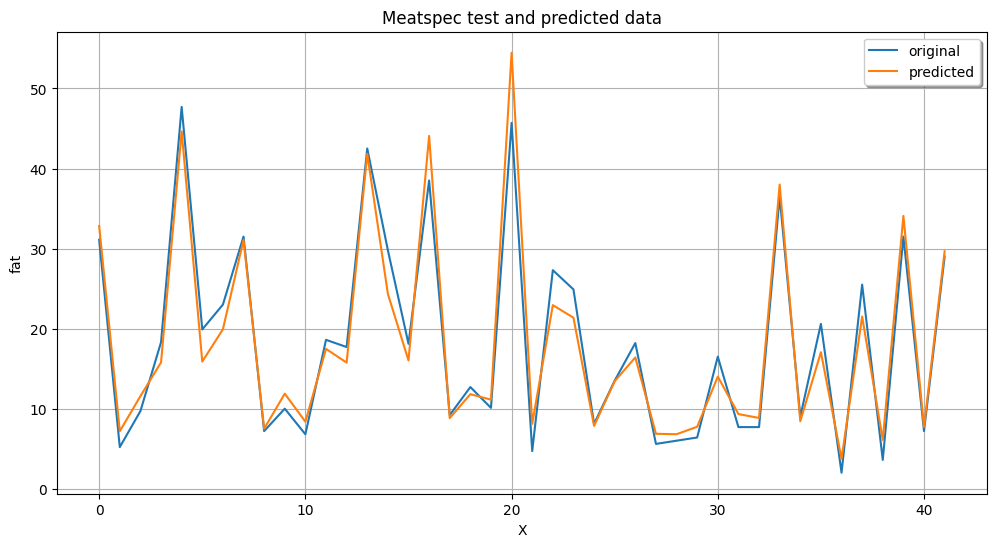

In [16]:
# visualizing in a plot
x_ax = range(len(y_test))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Meatspec test and predicted data")
plt.xlabel('X')
plt.ylabel('fat')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

* **Validación Cruzada**

In [17]:
# Define la métrica de evaluación (MAE)
mae_scorer = make_scorer(mean_absolute_error)

# Realiza la validación cruzada con 5 folds
mae_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring=mae_scorer)

# Imprime las puntuaciones MAE de cada fold y el promedio
print(f"Puntuaciones MAE en cada fold: {-mae_scores}")
print(f"MAE promedio: {-mae_scores.mean()}")

# Opcional: Realiza la validación cruzada para MSE y R²
mse_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"MSE promedio: {-mse_scores.mean()}")

r2_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
print(f"R² promedio: {r2_scores.mean()}")

Puntuaciones MAE en cada fold: [-2.13285162 -2.60030519 -1.80569204 -1.90793823 -1.9419544 ]
MAE promedio: -2.0777482976364867
MSE promedio: 18.2048772424956
R² promedio: 0.8795990902216075


## **LGB Regression**

In [18]:
import lightgbm as lgb
lgb_model=lgb.LGBMRegressor(verbose=-1)

# Ajusta el modelo a los datos de entrenamiento
lgb_model.fit(X_train,y_train)

# Realiza predicciones en los datos de prueba
y_pred = lgb_model.predict(X_test)

# Evalúa el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)


print('Mean Squared Error:', mse)
print('R-squared:', r2)
print('Mean Absolute Error:', mae)

Mean Squared Error: 49.61915874778007
R-squared: 0.6714271877285791
Mean Absolute Error: 5.414454802761955


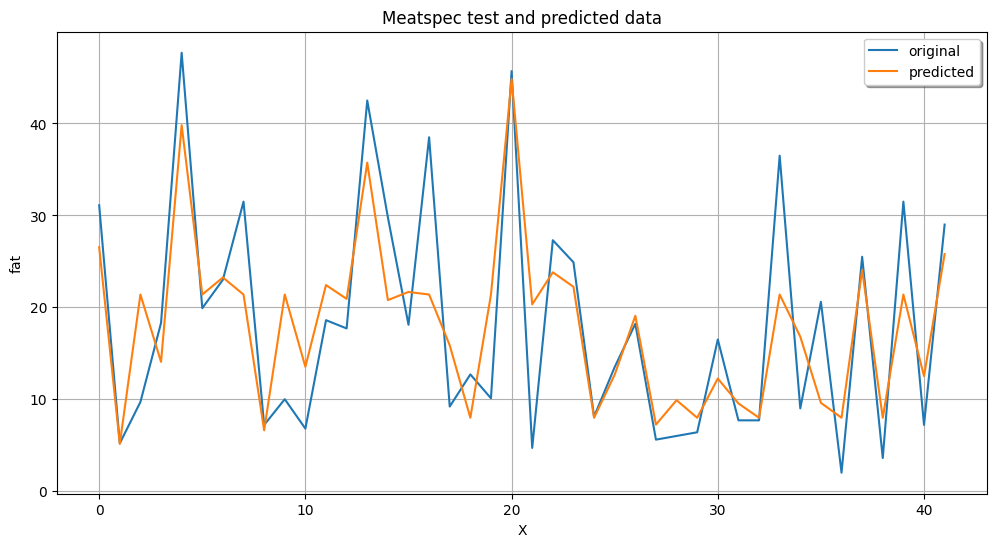

In [19]:
# visualizing in a plot
x_ax = range(len(y_test))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Meatspec test and predicted data")
plt.xlabel('X')
plt.ylabel('fat')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

In [20]:
# {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 5, 'metric': 'l2', 'n_estimators': 300, 'num_leaves': 10, 'objective': 'regression', 'shrinkage_rate': 0.05, 'verbose': -1}

In [29]:
# Defining parameters
param_grid =  {
    'num_leaves': [20, 31, 40],
    'learning_rate': [0.01, 0.1, 0.05],
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, -1],
    'Shrinkage Rate': [0.05, 0.1, 0.2],
    'boosting_type': ['gbdt', 'dart'],
    'objective': ['regression'],
    'metric': ['l2']
}

# Crear modelo LGBRegressor
lgb_model=lgb.LGBMRegressor()

# Crear objeto GridSearchCV
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Ajusta el modelo a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Realiza predicciones en los datos de prueba
y_pred = best_model.predict(X_test)

# Evalúa el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE en los datos de prueba: {mse}")
print(f"MAE en los datos de prueba: {mae}")
print(f"R² en los datos de prueba: {r2}")
print(f'Mejores hiperparámetros: {grid_search.best_params_}')

MSE en los datos de prueba: 48.812651855416846
MAE en los datos de prueba: 5.204312968084951
R² en los datos de prueba: 0.6767677909235481
Mejores hiperparámetros: {'Shrinkage Rate': 0.05, 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 5, 'metric': 'l2', 'n_estimators': 300, 'num_leaves': 20, 'objective': 'regression'}


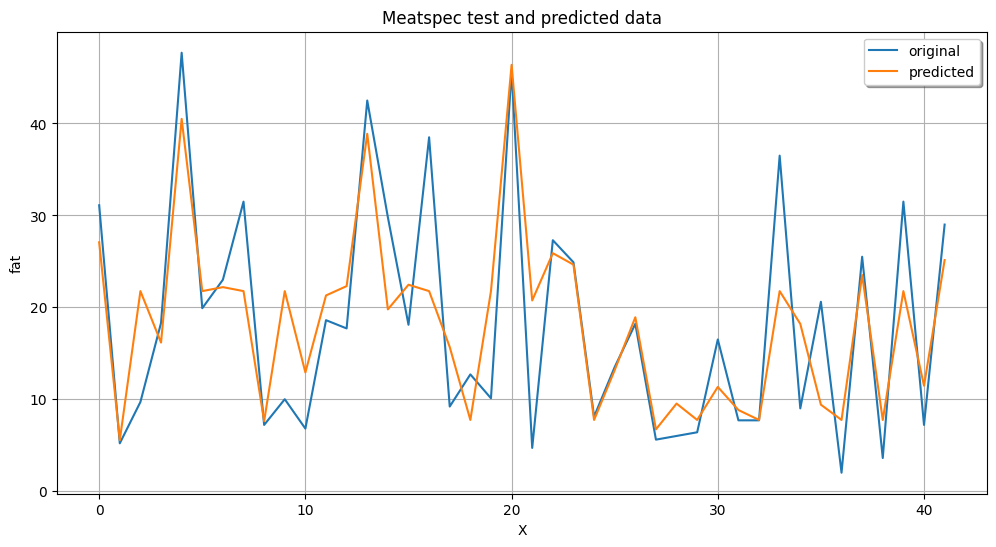

In [30]:
# visualizing in a plot
x_ax = range(len(y_test))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Meatspec test and predicted data")
plt.xlabel('X')
plt.ylabel('fat')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

In [47]:
# Define la métrica de evaluación (MAE)
mae_scorer = make_scorer(mean_absolute_error)

# Realiza la validación cruzada con 5 folds
mae_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring=mae_scorer)

# Imprime las puntuaciones MAE de cada fold y el promedio
print(f"Puntuaciones MAE en cada fold: {-mae_scores}")
print(f"MAE promedio: {-mae_scores.mean()}")

# Opcional: Realiza la validación cruzada para MSE y R²
mse_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"MSE promedio: {-mse_scores.mean()}")

r2_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')
print(f"R² promedio: {r2_scores.mean()}")

Puntuaciones MAE en cada fold: [-7.09347645 -4.56583141 -5.93515229 -4.70560812 -4.56038159]
MAE promedio: -5.372089971352952
MSE promedio: 54.35280542730614
R² promedio: 0.6317264193259629


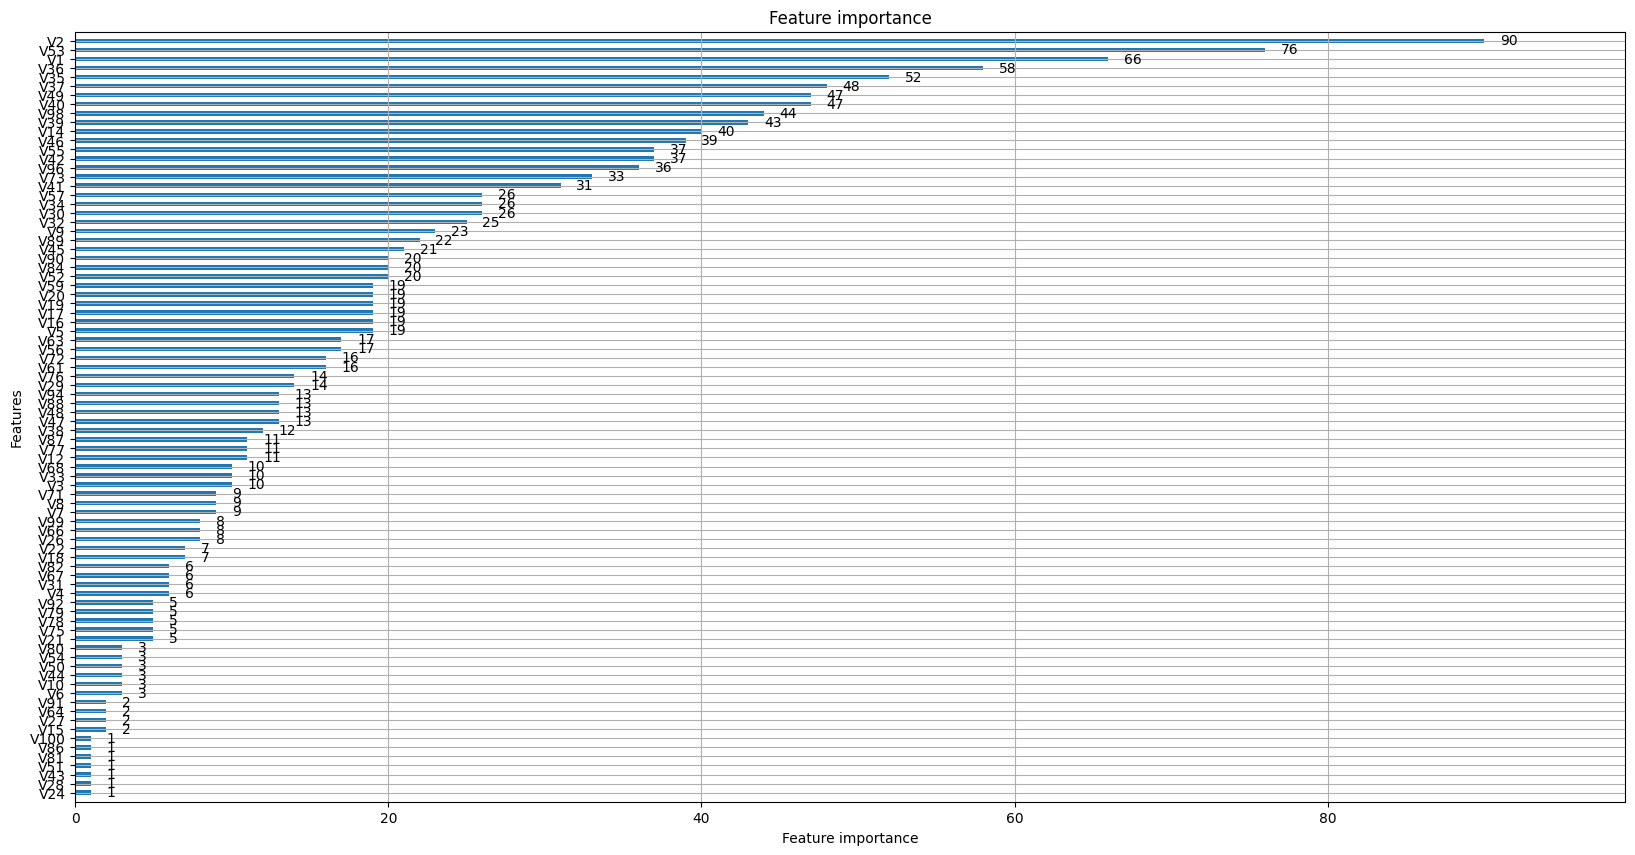

In [37]:
# Crear una figura y ejes manualmente
fig, ax = plt.subplots(figsize=(20, 10))  # Cambia los valores para agrandar más

# Dibujar la importancia de las características usando los ejes especificados
lgb.plot_importance(best_model, height=0.5, ax=ax)

# Mostrar el gráfico
plt.show()

## **Redes Neuronales**

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [39]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

# Crear el modelo
model = Sequential()

# Capa de entrada con 100 variables
model.add(Dense(256, activation='relu', input_shape=(100,), kernel_regularizer=l2(0.001)))

# Añadir capas ocultas con más neuronas y dropout para regularización
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))  # Dropout para prevenir sobreajuste

model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))

# Capa de salida con 1 neurona (regresión)
model.add(Dense(1))

# Compilar el modelo usando un optimizador con tasa de aprendizaje ajustada
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


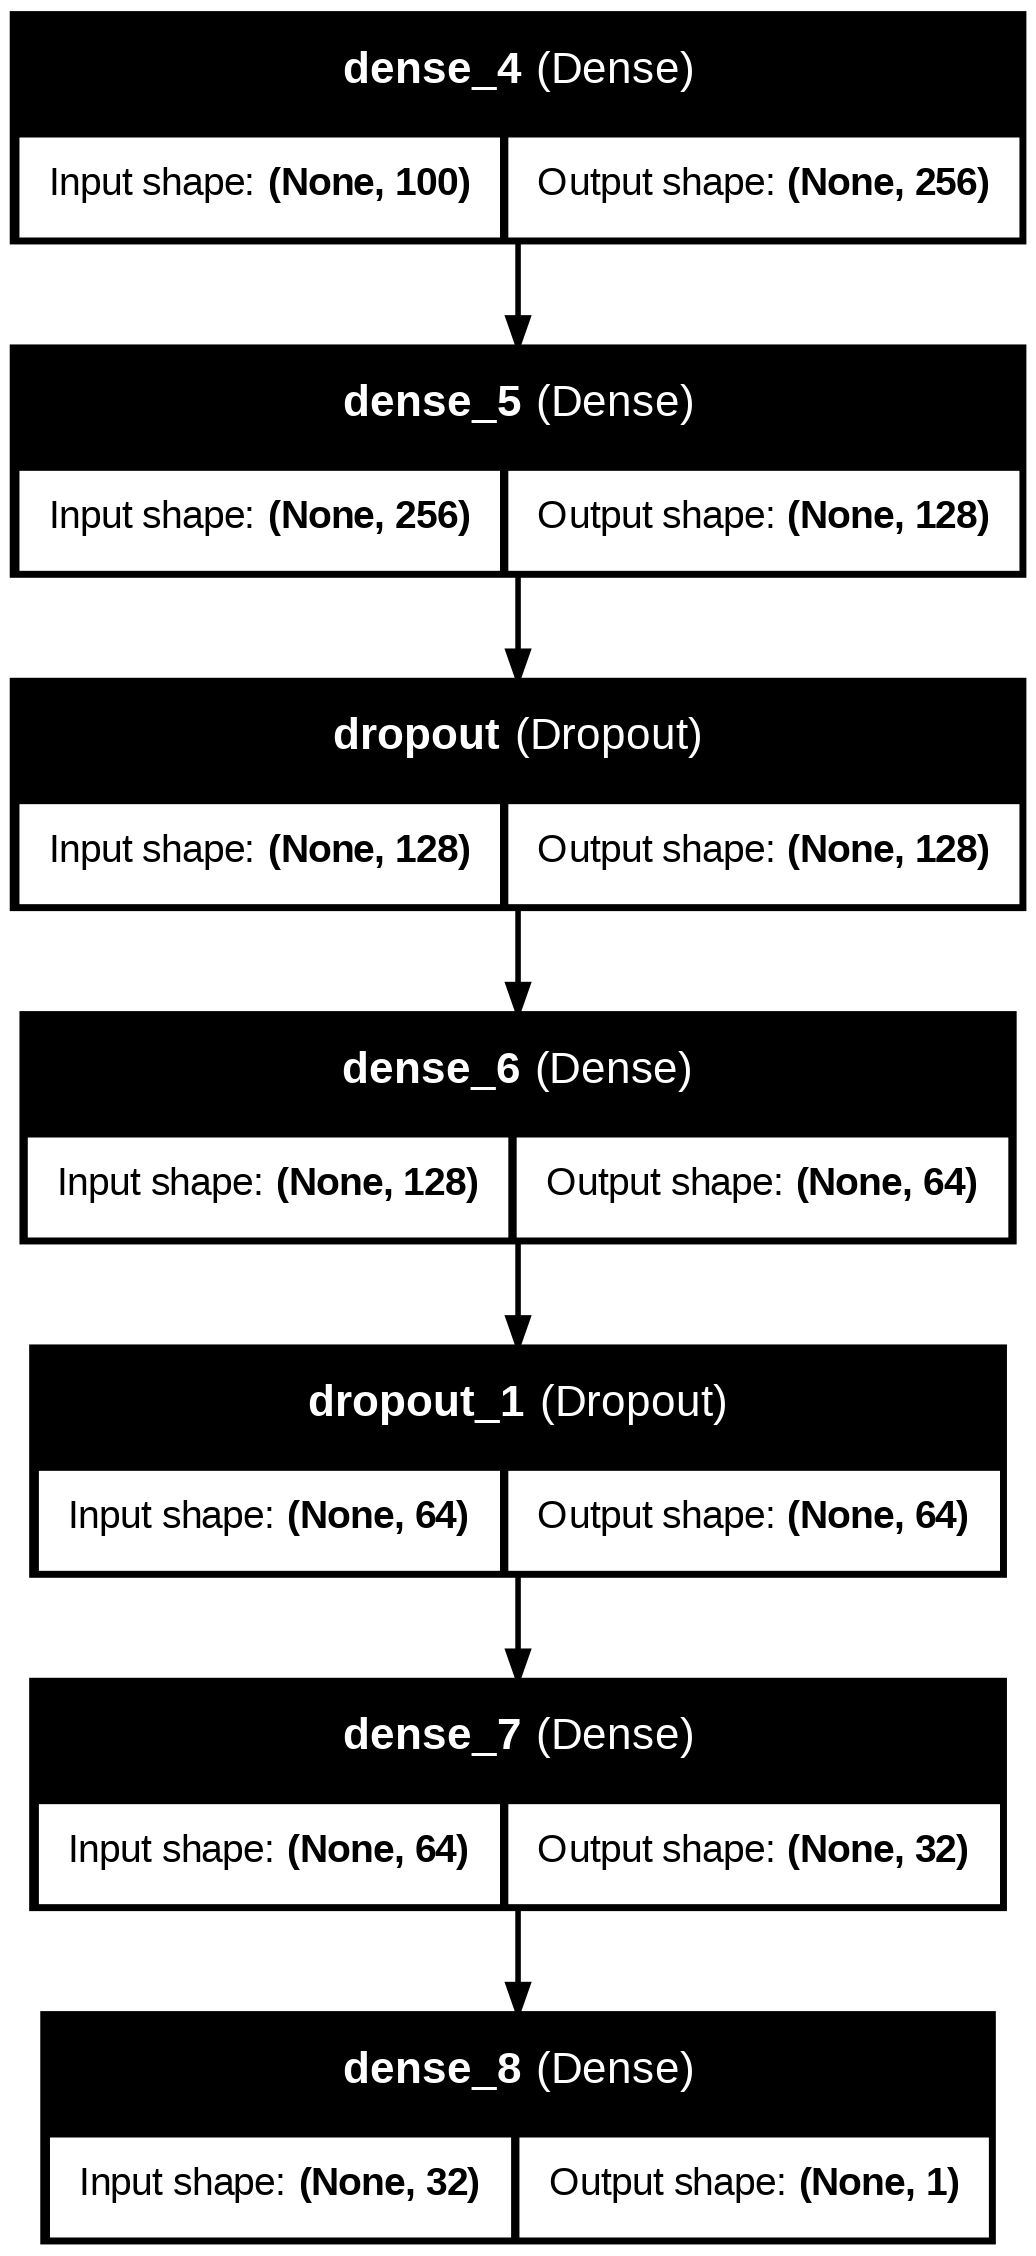

In [61]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

In [55]:
# Entrenar el modelo
history = model.fit(X_train_scaled, y_train, epochs=150, batch_size=32, validation_split=0.2)
# Evaluar en el conjunto de prueba
test_loss, test_mae = model.evaluate(X_test_scaled, y_test)

Epoch 1/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 38.8602 - mae: 4.7960 - val_loss: 38.2841 - val_mae: 4.5564
Epoch 2/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 38.1328 - mae: 4.8694 - val_loss: 26.3399 - val_mae: 4.0597
Epoch 3/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 39.8672 - mae: 4.6457 - val_loss: 34.9338 - val_mae: 3.8560
Epoch 4/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 30.9702 - mae: 4.1345 - val_loss: 18.1140 - val_mae: 3.2524
Epoch 5/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 26.3644 - mae: 3.7799 - val_loss: 16.8636 - val_mae: 3.1655
Epoch 6/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 29.8306 - mae: 4.0196 - val_loss: 21.1893 - val_mae: 3.1935
Epoch 7/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 31.2740 - mae: 3.9431 - val_loss: 14.9211 - val_mae: 3.0595
Epoch 8/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 23.6848 - mae: 3.5603 - val_loss: 15.2302 - val_mae: 3.3547
Epoch 9/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss

In [56]:
print(f"Mean Absolute Error en test: {test_mae}")
# Hacer predicciones
y_pred = model.predict(X_test_scaled)

Mean Absolute Error en test: 2.9840736389160156
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [57]:
# Calcular MSE, MAE y R²
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Mostrar las métricas
print(f"MSE en los datos de prueba: {mse}")
print(f"MAE en los datos de prueba: {mae}")
print(f"R² en los datos de prueba: {r2}")


MSE en los datos de prueba: 13.352211848729294
MAE en los datos de prueba: 2.984073709306263
R² en los datos de prueba: 0.9115830677524929


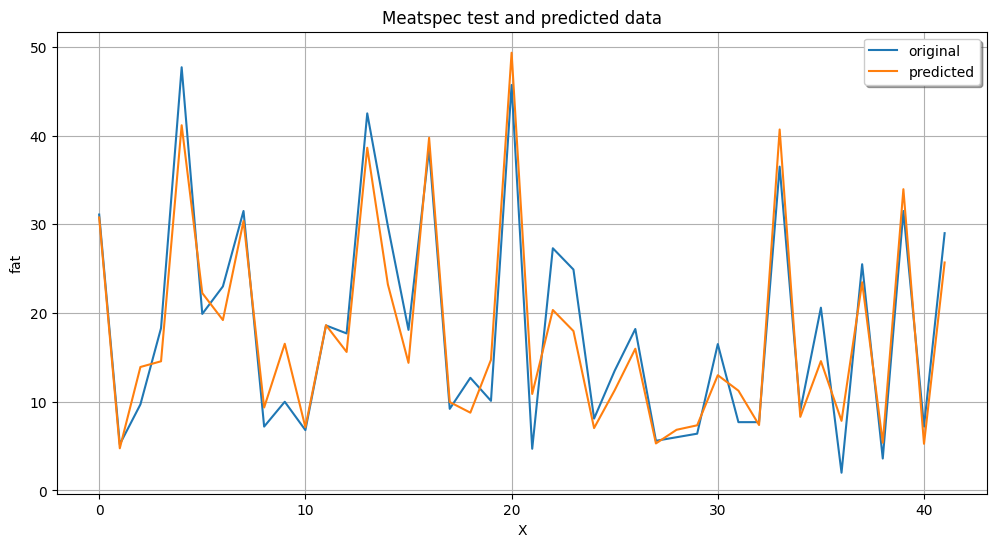

In [58]:
# visualizing in a plot
x_ax = range(len(y_test))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Meatspec test and predicted data")
plt.xlabel('X')
plt.ylabel('fat')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

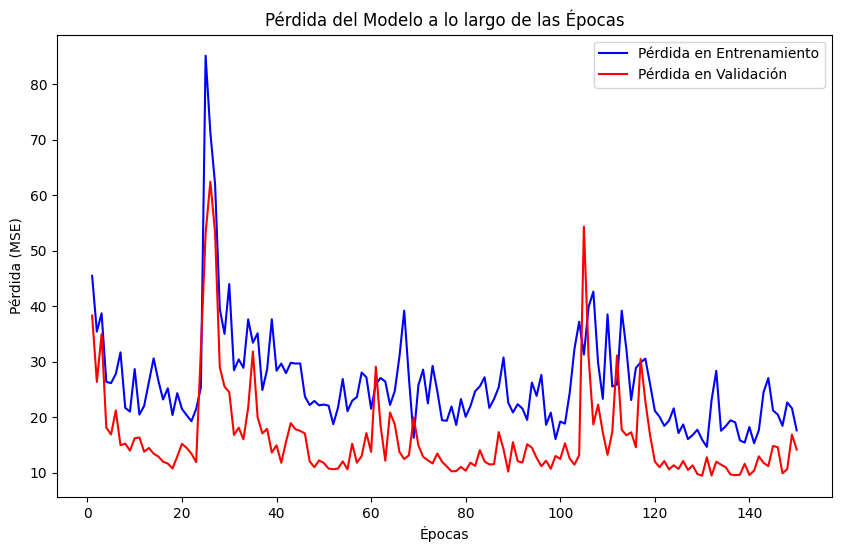

In [59]:
# Obtener los valores de pérdida para entrenamiento y validación
loss_train = history.history['loss']
loss_val = history.history['val_loss']

epochs = range(1, len(loss_train) + 1)

# Graficar la pérdida
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_train, 'b-', label='Pérdida en Entrenamiento')
plt.plot(epochs, loss_val, 'r-', label='Pérdida en Validación')
plt.title('Pérdida del Modelo a lo largo de las Épocas')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.show()

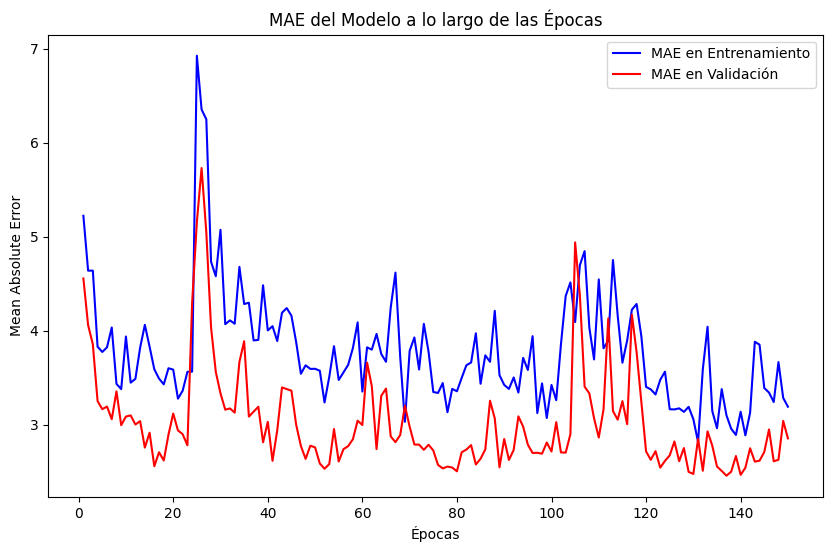

In [60]:
# Obtener los valores de MAE para entrenamiento y validación
mae_train = history.history['mae']
mae_val = history.history['val_mae']

# Graficar el MAE
plt.figure(figsize=(10, 6))
plt.plot(epochs, mae_train, 'b-', label='MAE en Entrenamiento')
plt.plot(epochs, mae_val, 'r-', label='MAE en Validación')
plt.title('MAE del Modelo a lo largo de las Épocas')
plt.xlabel('Épocas')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()